# （3）交通标志识别

## 1．解压和显示数据
步骤 1 导入本项目所需要的模块与包。  
步骤 2 解压 traffic.tar 文件到 Jupyter 工作目录下。  
步骤 3 定义显示图像函数，参数为存储图像的文件夹。① 显示数据集大小；② 随机抽取图像存入列表；③ 显示列表中的图像。  
步骤 4 调用函数显示部分训练图像。  
<i>首先，将本次实验的数据“traffic.tar”文件复制到 Jupyter 工作目录中，也可将数据文件放于其他文件夹，如果放于其他文件夹，修改变量 data_set_path（其值为压缩文件的存放路径）的值即可。<i/>

数据集大小为： 4200


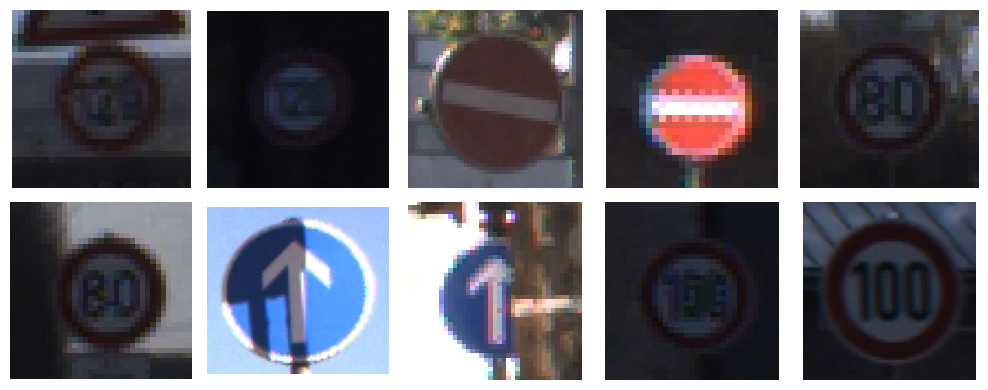

In [1]:
# 导入所需要的模块与包
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import tarfile

# 解压文件
data_set_path = "./"  # 数据集目录
archive_file = "traffic.tar"  # 压缩文件名
archive_path = os.path.join(data_set_path, archive_file)

# 解压压缩文件
tarfile.open(archive_path).extractall(path=data_set_path)

# 定义显示图像的函数
def display_image(data_dir):
    """
    显示指定数据目录下的随机图片样本。
    :param data_dir: 数据集的根目录
    """
    x_dir = []  # 存储子目录路径
    x_filename = []  # 存储子目录中的文件名
    x_len = 0  # 数据集图片总数

    # 遍历 5 个子目录并统计文件数
    for i in range(5):
        dir_path = os.path.join(data_dir, str(i))  # 构建子目录路径
        x_dir.append(dir_path)
        x_filename.append(os.listdir(dir_path))  # 获取子目录中的文件名列表
        x_len += len(x_filename[i])  # 累加图片数量

    # 打印数据集总大小
    print("数据集大小为：", x_len)

    # 随机抽取每个类别中的 2 张图片
    image = []
    for i in range(5):  # 遍历子目录
        for _ in range(2):  # 每个类别随机抽取 2 张图片
            t = np.random.randint(0, len(x_filename[i]))  # 随机索引
            image.append(os.path.join(x_dir[i], x_filename[i][t]))  # 存储随机图片路径

    # 显示抽取的图片
    plt.figure(figsize=(10, 4))  # 设置画布大小
    for i, img_path in enumerate(image, start=1):
        plt.subplot(2, 5, i)  # 创建 2x5 的子图布局
        img = mpimg.imread(img_path)  # 读取图片
        plt.imshow(img)  # 显示图片
        plt.axis('off')  # 隐藏坐标轴
    plt.tight_layout()  # 自动调整子图间距
    plt.show()

# 调用函数显示图像
display_image("./traffic/train/")  # 数据集根目录


## 2．数据预处理
步骤 1 对训练集做数据归一化及增强处理，数据增强包括数据旋转、平移、剪切、缩放、翻转等。  
步骤 2 对验证集做数据归一化处理。

In [2]:
import tensorflow as tf

# 定义训练集目录
TRAINING_DIR = "./traffic/train/"

# 定义训练数据增强器
training_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,            # 将像素值归一化到 [0, 1]
    rotation_range=40,         # 随机旋转角度范围
    width_shift_range=0.2,     # 随机水平平移范围
    height_shift_range=0.2,    # 随机垂直平移范围
    shear_range=0.2,           # 随机剪切变换范围
    zoom_range=0.2,            # 随机缩放范围
    horizontal_flip=True,      # 随机水平翻转
    fill_mode='nearest'        # 填充方式为最近邻插值
)

# 生成训练数据集
train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,              # 数据集目录
    target_size=(150, 150),    # 调整图像大小为 (150, 150)
    class_mode='categorical'   # 分类模式为多分类
)

# 定义验证集目录
VALIDATION_DIR = "./traffic/validation/"

# 定义验证数据增强器
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255  # 将像素值归一化到 [0, 1]
)

# 生成验证数据集
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,            # 数据集目录
    target_size=(150, 150),    # 调整图像大小为 (150, 150)
    class_mode='categorical'   # 分类模式为多分类
)


Found 4200 images belonging to 5 classes.
Found 600 images belonging to 5 classes.


## 3．构建网络模型
交通标志识别网络模型采用卷积神经网络，它包括 4 个卷积层、4 个池化层、6 个 Dropout 层、一个拉伸层、一个全连接层和一个输出层，网络结构如图所示。由于数据集中有 5 种交通标志图像，故应为输出
层设置 5 个神经元，使用 Softmax 函数作为激活函数。  
步骤 1 构建卷积神经网络模型对象 model。  
步骤 2 在 model 对象中添加第一组“卷积层+池化层+Dropout 层”，首先添加卷积层，输出通道数为64，卷积核大小为 3×3，使用 ReLU 函数作为激活函数，输入数据的形状为(150,150,3)；然后添加最大池
化层，池化窗口大小为 2×2；最后添加 Dropout 层，丢弃概率为 0.3。  
步骤 3 在 model 对象中添加第二组“卷积层+池化层+Dropout 层”，首先添加卷积层，输出通道数为64，卷积核大小为 3×3，使用 ReLU 函数作为激活函数；然后添加最大池化层，池化窗口大小为 2×2；最
后添加 Dropout 层，丢弃概率为 0.3。  
步骤 4 在 model 对象中添加第三组“卷积层+池化层+Dropout 层”，首先添加卷积层，输出通道数为128，卷积核大小为 3×3，使用 ReLU 函数作为激活函数；然后添加最大池化层，池化窗口大小为 2×2；
最后添加 Dropout 层，丢弃概率为 0.3。  
步骤 5 在 model 对象中添加第四组“卷积层+池化层+Dropout 层”，首先添加卷积层，输出通道数为128，卷积核大小为 3×3，使用 ReLU 函数作为激活函数；然后添加最大池化层，池化窗口大小为 2×2；
最后添加 Dropout 层，丢弃概率为 0.3。  
步骤 6 在 model 对象中添加拉伸层。  
步骤 7 在 model 对象中添加 Dropout 层，丢弃概率为 0.5。  
步骤 8 在 model 对象中添加全连接层，神经元个数为 512，使用 ReLU 函数作为激活函数。  
步骤 9 在 model 对象中添加 Dropout 层，丢弃概率为 0.5。  
步骤 10 在 model 对象中添加输出层，神经元个数为 5，激活函数采用 Softmax 函数。  
步骤 11 使用 summary()函数显示网络模型各层的参数信息。  

In [3]:
import tensorflow as tf

# 构建卷积神经网络模型
model = tf.keras.models.Sequential([
    # 第一组卷积层 + 池化层 + Dropout 层
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)),  # 卷积层
    tf.keras.layers.MaxPooling2D(2, 2),  # 池化层
    tf.keras.layers.Dropout(0.3),  # Dropout 层

    # 第二组卷积层 + 池化层 + Dropout 层
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),  # 卷积层
    tf.keras.layers.MaxPooling2D(2, 2),  # 池化层
    tf.keras.layers.Dropout(0.3),  # Dropout 层

    # 第三组卷积层 + 池化层 + Dropout 层
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),  # 卷积层
    tf.keras.layers.MaxPooling2D(2, 2),  # 池化层
    tf.keras.layers.Dropout(0.3),  # Dropout 层

    # 第四组卷积层 + 池化层 + Dropout 层
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),  # 卷积层
    tf.keras.layers.MaxPooling2D(2, 2),  # 池化层
    tf.keras.layers.Dropout(0.3),  # Dropout 层

    # 拉伸层（Flatten）和 Dropout 层
    tf.keras.layers.Flatten(),  # 展平层
    tf.keras.layers.Dropout(0.5),  # Dropout 层

    # 全连接层和 Dropout 层
    tf.keras.layers.Dense(512, activation='relu'),  # 全连接层
    tf.keras.layers.Dropout(0.5),  # Dropout 层

    # 输出层（5 分类问题，使用 softmax 激活函数）
    tf.keras.layers.Dense(5, activation='softmax')
])

# 显示模型各层的参数信息
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 74, 74, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 36, 36, 64)        0

## 4．编译、训练和保存网络模型
步骤 1 编译网络模型。其中，损失函数使用交叉熵损失函数，优化器使用 RMSprop 优化器，性能评估函数使用准确率函数。  
步骤 2 训练网络模型。其中，迭代次数为 10，日志显示模式为 1。  
步骤 3 保存网络模型和权重参数到 HDF5 文件中，文件名为“traffic.h5”。

In [4]:
# 编译网络模型
model.compile(
    loss='categorical_crossentropy',  # 损失函数：适用于多分类问题
    optimizer='rmsprop',             # 优化器：RMSProp
    metrics=['accuracy']             # 评估指标：准确率
)

# 训练网络模型
history = model.fit(
    train_generator,                 # 训练数据生成器
    epochs=10,                       # 训练轮数
    validation_data=validation_generator,  # 验证数据生成器
    verbose=1                        # 显示详细训练日志
)

# 保存训练好的网络模型
model.save("traffic.h5")  # 将模型保存为 H5 文件


Epoch 1/10
132/132 [==============================] - 31s 197ms/step - loss: 1.1886 - accuracy: 0.4855 - val_loss: 0.7134 - val_accuracy: 0.7633
Epoch 2/10
132/132 [==============================] - 24s 180ms/step - loss: 0.8188 - accuracy: 0.6269 - val_loss: 0.8177 - val_accuracy: 0.6533
Epoch 3/10
132/132 [==============================] - 24s 178ms/step - loss: 0.7322 - accuracy: 0.6495 - val_loss: 0.5391 - val_accuracy: 0.8717
Epoch 4/10
132/132 [==============================] - 24s 178ms/step - loss: 0.6831 - accuracy: 0.6840 - val_loss: 0.5818 - val_accuracy: 0.7983
Epoch 5/10
132/132 [==============================] - 24s 178ms/step - loss: 0.6583 - accuracy: 0.6943 - val_loss: 0.5929 - val_accuracy: 0.7133
Epoch 6/10
132/132 [==============================] - 23s 177ms/step - loss: 0.6383 - accuracy: 0.7190 - val_loss: 0.6808 - val_accuracy: 0.6867
Epoch 7/10
132/132 [==============================] - 24s 179ms/step - loss: 0.6164 - accuracy: 0.7198 - val_loss: 0.5678 - val_ac

## 5．可视化训练的结果
步骤 1 读取 history 的 history 属性，分别将训练集损失函数值赋值给变量 loss、训练集准确率赋值给变量 acc、验证集损失函数值赋值给变量 val_loss、验证集准确率赋值给变量 val_acc。  
步骤 2 创建子图，在子图 1 中绘制损失函数值的折线图。  
步骤 3 在子图 2 中绘制准确率的折线图。

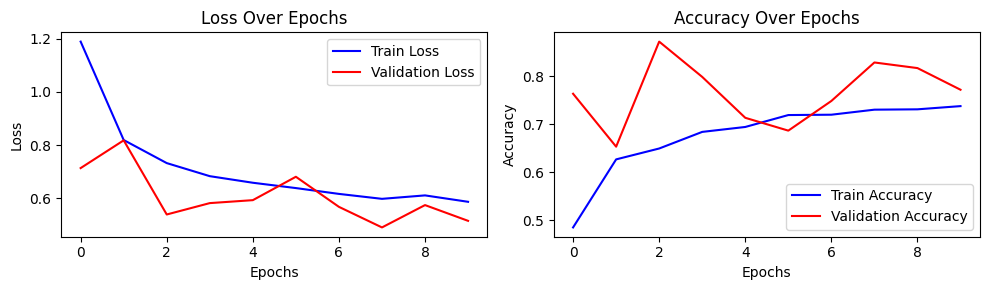

In [5]:
# 从 history 对象中提取训练过程中的数据
loss = history.history['loss']          # 训练集损失值
acc = history.history['accuracy']       # 训练集准确率
val_loss = history.history['val_loss']  # 验证集损失值
val_acc = history.history['val_accuracy']  # 验证集准确率

# 创建画布并设置画布的大小
plt.figure(figsize=(10, 3))

# 在子图 1 中绘制损失函数值的折线图
plt.subplot(1, 2, 1)  # 1 行 2 列的第 1 个子图
plt.plot(loss, color='b', label='Train Loss')  # 训练集损失值
plt.plot(val_loss, color='r', label='Validation Loss')  # 验证集损失值
plt.title('Loss Over Epochs')  # 设置标题
plt.ylabel('Loss')  # 设置 y 轴标签
plt.xlabel('Epochs')  # 设置 x 轴标签
plt.legend()  # 显示图例

# 在子图 2 中绘制准确率的折线图
plt.subplot(1, 2, 2)  # 1 行 2 列的第 2 个子图
plt.plot(acc, color='b', label='Train Accuracy')  # 训练集准确率
plt.plot(val_acc, color='r', label='Validation Accuracy')  # 验证集准确率
plt.title('Accuracy Over Epochs')  # 设置标题
plt.ylabel('Accuracy')  # 设置 y 轴标签
plt.xlabel('Epochs')  # 设置 x 轴标签
plt.legend()  # 显示图例

# 显示绘制的图像
plt.tight_layout()  # 自动调整子图间距
plt.show()


## 6．应用网络模型
步骤 1 定义读取测试集图像函数，函数参数为测试集文件夹的路径、读取图像开始位置、结束位置及图像的形状。① 获取测试集的文件列表；② 读取测试图像并转换为 NumPy 数组；③ 返回标准化处理后的测试图像数据。  
步骤 2 定义预测函数，函数参数为测试集文件夹的路径、读取图像开始位置、结束位置及图像的形状。① 读取测试图像并进行预处理；② 使用训练好的模型对测试数据进行预测；③ 显示图像及预测结果。  
步骤 3 调用预测函数，读取测试数据进行预测并显示预测结果。

1/1 [==============================] - 0s 115ms/step


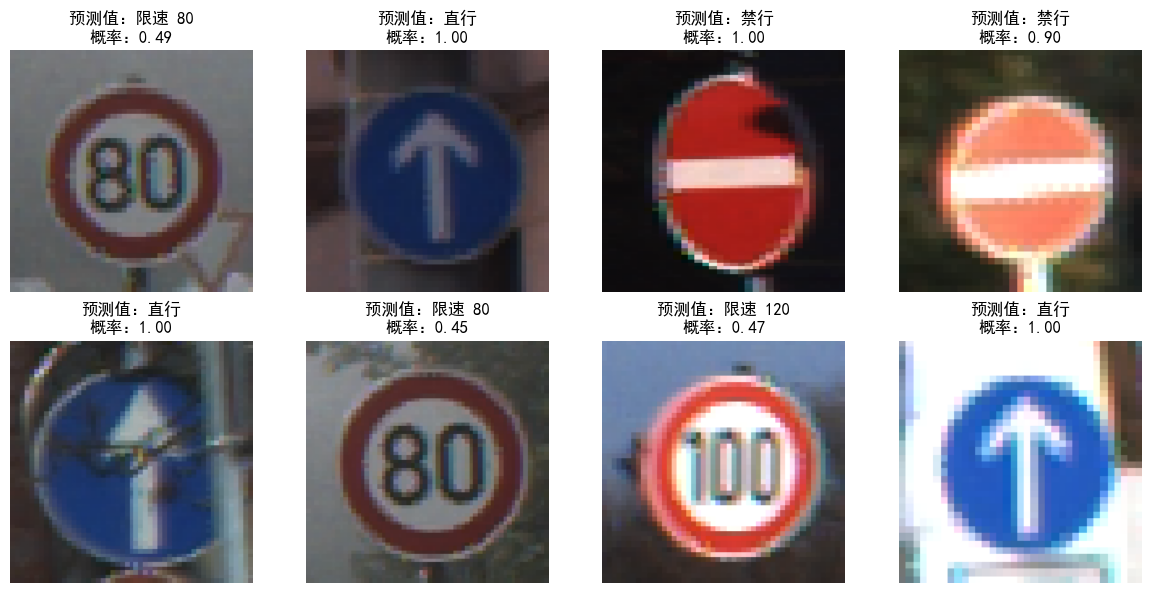

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

# 定义读取测试集图像的函数
def read_image_files(path, start, finish, image_size=(150, 150)):
    """
    读取指定范围的测试集图像并进行预处理。
    :param path: 测试集目录
    :param start: 开始索引
    :param finish: 结束索引
    :param image_size: 图像大小 (默认: 150x150)
    :return: 标准化后的测试图像数据
    """
    test_files = os.listdir(path)
    test_images = []

    # 读取测试图像并调整大小
    for fn in test_files[start:finish]:
        img_filename = os.path.join(path, fn)  # 构建完整路径
        img = tf.keras.preprocessing.image.load_img(img_filename, target_size=image_size)  # 加载图像
        img_array = tf.keras.preprocessing.image.img_to_array(img)  # 转换为数组
        test_images.append(img_array)

    # 转换为 NumPy 数组并标准化
    test_data = np.array(test_images) / 255.0  # 标准化到 [0, 1]
    return test_data

# 定义预测测试集图像的函数
def test_image_predict(path, start, finish, image_size=(150, 150)):
    """
    使用模型对测试集图像进行预测，并显示预测结果。
    :param path: 测试集目录
    :param start: 开始索引
    :param finish: 结束索引
    :param image_size: 图像大小 (默认: 150x150)
    """
    # 读取测试图像
    test_data = read_image_files(path, start, finish, image_size)
    
    # 执行预测
    preds = model.predict(test_data)

    # 显示图像及预测结果
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
    plt.figure(figsize=(12, 6))  # 设置画布大小
    for i in range(0, finish - start):
        plt.subplot(2, 4, i + 1)  # 创建子图布局
        # 根据预测结果设置标签
        if np.argmax(preds[i]) == 0:
            label = f"预测值：限速 120\n概率：{preds[i][0]:.2f}"
        elif np.argmax(preds[i]) == 1:
            label = f"预测值：禁行\n概率：{preds[i][1]:.2f}"
        elif np.argmax(preds[i]) == 2:
            label = f"预测值：限速 80\n概率：{preds[i][2]:.2f}"
        elif np.argmax(preds[i]) == 3:
            label = f"预测值：直行\n概率：{preds[i][3]:.2f}"
        else:
            label = f"预测值：限速 100\n概率：{preds[i][4]:.2f}"
        
        plt.title(label)  # 设置标题
        plt.imshow(test_data[i])  # 显示图像
        plt.axis('off')  # 隐藏坐标轴
    plt.tight_layout()  # 自动调整子图间距
    plt.show()

# 调用测试函数
test_data_dir = './traffic/test/'  # 测试数据集目录
test_image_predict(test_data_dir, 0, 8)  # 预测测试集前 8 张图像
